In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

from heatmapcluster import heatmapcluster

CPU times: user 1.18 s, sys: 286 ms, total: 1.46 s
Wall time: 2.28 s


In [4]:
tree = uproot.open("Run9goodDataQ_dualgate.root")["tree"]
energy = tree.array("Energy")
print(tree)
del tree
energy = energy[:,1]

label = np.load("label.npy")
label2 = np.load("label_4.npy")
survives = np.load("survives.npy")
final = np.load("final.npy")
final_final = np.load("final_final.npy")
really_final = np.load("really_final.npy")

energy1 = energy[label==4]
energy2 = energy1[label2==1]
energy3 = energy2[survives==0]
energy4 = energy3[final==1]
energy5 = energy4[final_final==1]
energy6 = energy5[really_final==1]

<TTree b'tree' at 0x000146b477b8>


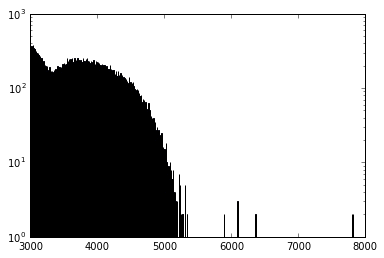

In [17]:
plt.hist(energy,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

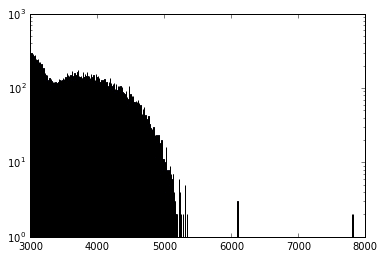

In [18]:
plt.hist(energy1,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

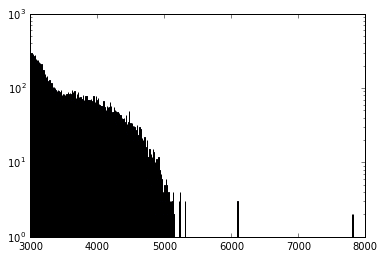

In [19]:
plt.hist(energy2,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

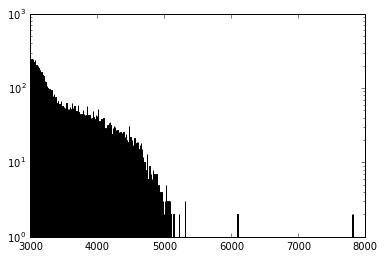

In [20]:
plt.hist(energy3,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

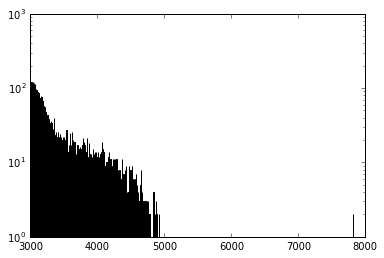

In [21]:
plt.hist(energy4,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

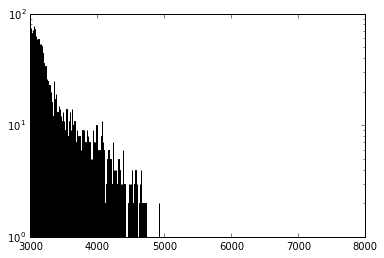

In [23]:
plt.hist(energy5,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

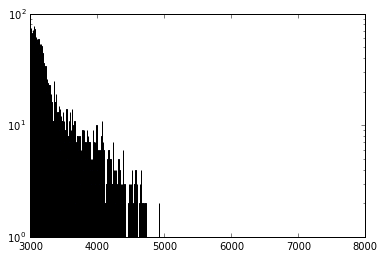

In [24]:
plt.hist(energy6,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [2]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]
#         number = 
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        survives = np.load("survives.npy")
        final = np.load("final.npy")
        final_final = np.load("final_final.npy")
        really_final = np.load("really_final.npy")

        # random labelling(test purposes)
        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,tree,pedestal,pedestal_sum
        waveform_1 = waveform_n[label==4]
        waveform_2 = waveform_1[label2==1]
        waveform_3 = waveform_2[survives==0]
        waveform_4 = waveform_3[final==1]
        waveform_5 = waveform_4[final_final==1]
        self.waveform = waveform_5[really_final==1]
        del waveform_n,waveform_1,waveform_2,waveform_3,waveform_4,waveform_5
#         self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]



CPU times: user 42 µs, sys: 1 µs, total: 43 µs
Wall time: 50.1 µs


In [3]:
dataset = Waveform(path="Run9goodDataQ_dualgate.root")

In [4]:
BATCH_SIZE = 3000
data_loader = DataLoader(dataset=dataset,
                         batch_size=100,
                         shuffle=False,
                         num_workers=3) 

In [5]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(16, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(16, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([32])
torch.Size([32, 32,

In [6]:
GEN.load_state_dict(torch.load("GEN_WEIGHT_quarter.pkl"))

In [7]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

In [11]:
%%time
try:
    for batch_number, waveform in enumerate(data_loader):
#         average = []
#         average2 = []
#         average3 = []
#         average4 = []
#         print(batch_number,label.size())
#         print(waveform.size())
#         if batch_number == 10:
#             break

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
#         print(batch_number)
#         print(feat[0].size())
        
        green = features[0].detach().numpy()
        row_labels = [('R%02d' % k) for k in range(green.shape[0])]
        col_labels = [('C%02d' % k) for k in range(green.shape[1])]
        
        h = heatmapcluster(green, row_labels, col_labels,
                   num_row_clusters=3, num_col_clusters=0,
                   label_fontsize=6,
                   xlabel_rotation=-75,
                   cmap=plt.cm.coolwarm,
                   show_colorbar=True,
                   top_dendrogram=True)
        plt.show()
        
        
# #         print(green.shape)
#         Z = linkage(green, method="ward")
# #         print(Z.shape)
# #         print(Z)
#         fig = plt.figure(figsize=(12, 8))
# #         dn = dendrogram(Z)
# #         plt.title(batch_number)
# # #         plt.savefig("ref.png")
# #         plt.show()
        
#         clusters = fcluster(Z, 0.05, criterion='distance')
# #         print(clusters.shape)
# #         print(clusters)
#         print(np.unique(clusters))
        
# #         average = np.append(average,Z)
        
#         for i, waveform_out in enumerate(feat[0]):
            
#             red = waveform_out.detach().numpy()
# #             red = np.reshape(waveform_out.detach().numpy(), (1,-1))
#             blue = waveform_in[i].detach().numpy()
# #             blue = normalize(waveform_in[i].detach().numpy(),axis=1)

# #             print(i, red.shape,blue.shape)
# #             print(red[0])
# #             print(blue[0])

# #             plt.figure()
# #             plt.title("{}".format(clusters[i]))
# #             plt.plot(red[0],label="encoder output",alpha=0.7)
# #             plt.plot(blue[0],label="encoder input",alpha=0.7)
# #             plt.legend()
# # #                     plt.savefig("fig/{}_{}.png".format(k,i))
# #             plt.show()
    
# #             for k in range(len(np.unique(clusters))):
# #                 if k==clusters[i]:
# #                     plt.figure()
# #                     plt.title("{}".format(k))
# #                     plt.plot(red[0],label="encoder output",alpha=0.7)
# #                     plt.plot(blue[0],label="encoder input",alpha=0.7)
# #                     plt.legend()
# # #                     plt.savefig("fig/{}_{}.png".format(k,i))
# #                     plt.show()
#             if clusters[i]==24:
#                 plt.figure()
#                 plt.plot(blue[0])
#                 plt.xlim(50,2000)
#                 plt.show()
    
# #             if clusters[i]==1:
# #                 average.append(blue[0])
                
# #             if clusters[i]==2:
# #                 average2.append(blue[0])
            
# #             if clusters[i]==3:
# #                 average3.append(blue[0])
                
# #             if clusters[i]==4:
# #                 average4.append(blue[0])
# #         dang = np.mean(average, axis=0)
# #         dang2 = np.mean(average2, axis=0)
# #         dang3 = np.mean(average3, axis=0)
#         dang4 = np.mean(average4, axis=0)
        
# #         plt.figure(figsize=(12,8))
# #         plt.plot(dang,label="1")
# #         plt.plot(dang2,label="2")
# #         plt.plot(dang3,label="3")
# #         plt.plot(dang4,label="4")
# #         plt.xlim(70,350)
# #         plt.xlabel("channel")
# #         plt.legend()
# #         plt.title(batch_number)
# #         plt.show()
                    
# #         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
# #         print(Features.size())
#     # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
#     # print(db.core_sample_indices_)
#     # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')

ValueError: A 2-dimensional array must be passed.

### 